## Learning the policies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator 

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

figpath = "./figs"

In [3]:
fig_prefix = "main-paper"

In [4]:
SEED = 1  # Note this is not the only random seed, see the loop

In [5]:
np.random.seed(SEED)
NSIMSAMPS = 1000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

PROB_DIAB = 0.2

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars; 
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

## Transition / Reward Mats for full-information vs. marginalized MDP

First, we'll load the transition and reward matricies from file.  Because our simulator works in "vitals space" according to clinical logic, we need to do some legwork to convert this to a matrix representation.  Most notably, due to the complexity of the transitions in the simulator, it is not straightforward to read out the transition matrix from the simulator code, so we estimate it using a large amount of data from each transition (see the relevant notebook `learn_mdp_paramters.ipynb`)

Once we have this "ground truth" transition / reward matrix learned from an arbitrarily large amount of data (or rather, two transition / reward matricies, one for each value of diabetes), we will manipulate it to construct the "observed" transition / reward matricies used by the physician and RL policies respectively.

In [6]:
# Get the transition and reward matrix from file
with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]
p_mixture = np.array([1 - PROB_DIAB, PROB_DIAB])

In [7]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [8]:
%%time
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

physPolSoft = np.copy(fullPol)
physPolSoft[physPolSoft == 1] = 1 - PHYS_EPSILON
physPolSoft[physPolSoft == 0] = PHYS_EPSILON / (n_actions - 1)

CPU times: user 26.3 s, sys: 3.3 s, total: 29.6 s
Wall time: 5.18 s


In [9]:
obs_reward = []
offpol_opt_reward_WIS_hard = []                         
offpol_opt_reward_WIS_soft = [] 
offpol_opt_reward_mb = []
offpol_opt_reward_cf = []
true_rl_reward = []

# Store all of our samples
all_samps = []

# Store all of the samples selected by Hard WIS
wis_samps = []

# Track the number of samples which match per WIS
wis_counts = []

# We will save the detailed samples from the first run
saved_material = None

In [10]:
# This is a QA function to ensure that the RL policy is only taking actions that have been observed
def check_rl_policy(rl_policy, obs_samps, proj_lookup):
    passes = True
    # Check the observed actions for each state
    obs_pol = np.zeros_like(rl_policy)
    for eps_idx in range(NSIMSAMPS):
        for time_idx in range(NSTEPS):
            this_obs_action = int(obs_samps[eps_idx, time_idx, 1])
            # Need to get projected state
            if this_obs_action == -1:
                continue
            this_obs_state = proj_lookup[int(obs_samps[eps_idx, time_idx, 2])]
            obs_pol[this_obs_state, this_obs_action] += 1

    # Check if each RL action conforms to an observed action
    for eps_idx in range(NSIMSAMPS):
        for time_idx in range(NSTEPS):
            this_full_state_unobserved = int(obs_samps[eps_idx, time_idx, 1])
            this_obs_state = proj_lookup[this_full_state_unobserved]
            this_obs_action = int(obs_samps[eps_idx, time_idx, 1])

            if this_obs_action == -1:
                continue
            # This is key: In some of these trajectories, you die or get discharge.  
            # In this case, no action is taken because the sequence has terminated, so there's nothing to compare the RL action to
            true_death_states = r_mat[0, 0, 0, :] == -1
            true_disch_states = r_mat[0, 0, 0, :] == 1
            if np.logical_or(true_death_states, true_disch_states)[this_full_state_unobserved]:
                continue

            this_rl_action = rl_policy[proj_lookup[this_obs_state]].argmax()
            if obs_pol[this_obs_state, this_rl_action] == 0:
                print("Eps: {} \t RL Action {} in State {} never observed".format(
                    int(time_idx / NSTEPS), this_rl_action, this_obs_state))
                passes = False
    return passes

In [11]:
# Construct the projection matrix for obs->proj states
n_proj_states = int((n_states_abs - 2) / 5) + 2
proj_matrix = np.zeros((n_states_abs, n_proj_states))
for i in range(n_states_abs - 2):
    this_state = State(state_idx = i, idx_type='obs', 
                       diabetic_idx = 1)  # Diab a req argument, no difference
    # assert this_state == State(state_idx = i, idx_type = 'obs', diabetic_idx = 0)
    j = this_state.get_state_idx('proj_obs')
    proj_matrix[i, j] = 1

# Add the projection to death and discharge
proj_matrix[deadStateIdx, -2] = 1
proj_matrix[discStateIdx, -1] = 1

proj_matrix = proj_matrix.astype(int)

proj_lookup = proj_matrix.argmax(axis=-1)

In [12]:
for it in tqdm(range(N_REPEAT_SAMPLING), desc="Outer Loop"):
    np.random.seed(it)
    dgen = DataGenerator()

    states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
       NSIMSAMPS, NSTEPS, policy=physPolSoft, policy_idx_type='full', 
       p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

    obs_samps = utils.format_dgen_samps(
       states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

    emp_tx_mat = np.copy(emp_tx_totals)
    emp_r_mat = np.copy(emp_r_totals)

    ############## Construct the Transition Matrix w/proj states ##############
    proj_tx_cts = np.zeros((n_actions, n_proj_states, n_proj_states))
    proj_tx_mat = np.zeros_like(proj_tx_cts)

    # (1) NOTE: Previous code marginalized here, but now we are just getting observed quantities out, no components
    est_tx_cts = np.copy(emp_tx_totals)
    assert est_tx_cts.ndim == 3

    # (2) Add new aborbing states, and a new est_tx_mat with Absorbing states
    death_states = (emp_r_mat.sum(axis=0).sum(axis=0) < 0)
    disch_states = (emp_r_mat.sum(axis=0).sum(axis=0) > 0)

    est_tx_cts_abs = np.zeros((n_actions, n_states_abs, n_states_abs))
    est_tx_cts_abs[:, :-2, :-2] = np.copy(est_tx_cts)

    death_states = np.concatenate([death_states, np.array([True, False])])
    disch_states = np.concatenate([disch_states, np.array([False, True])])
    assert est_tx_cts_abs[:, death_states, :].sum() == 0
    assert est_tx_cts_abs[:, disch_states, :].sum() == 0

    est_tx_cts_abs[:, death_states, deadStateIdx] = 1
    est_tx_cts_abs[:, disch_states, discStateIdx] = 1

    # (3) Project the new est_tx_cts_abs to the reduced state space
    for a in range(n_actions):
        proj_tx_cts[a] = proj_matrix.T.dot(est_tx_cts_abs[a]).dot(proj_matrix)

    # Normalize
    nonzero_idx = proj_tx_cts.sum(axis=-1) != 0
    proj_tx_mat[nonzero_idx] = proj_tx_cts[nonzero_idx]

    proj_tx_mat[nonzero_idx] /= proj_tx_mat[nonzero_idx].sum(axis=-1, keepdims=True)

    ############ Construct the reward matrix, which is known ##################
    proj_r_mat = np.zeros((n_actions, n_proj_states, n_proj_states))
    proj_r_mat[..., -2] = -1
    proj_r_mat[..., -1] = 1

    proj_r_mat[..., -2, -2] = 0 # No reward once in aborbing state
    proj_r_mat[..., -1, -1] = 0

    ############ Construct the empirical prior on the initial state ##################
    initial_state_arr = np.copy(states[:, 0, 0])
    initial_state_counts = np.zeros((n_states_abs,1))
    for i in range(initial_state_arr.shape[0]):
        initial_state_counts[initial_state_arr[i]] += 1

    # Project initial state counts to new states
    proj_state_counts = proj_matrix.T.dot(initial_state_counts).T
    proj_p_initial_state = proj_state_counts / proj_state_counts.sum()

    # Because some SA pairs are never observed, assume they cause instant death
    zero_sa_pairs = proj_tx_mat.sum(axis=-1) == 0
    proj_tx_mat[zero_sa_pairs, -2] = 1  # Always insta-death if you take a never-taken action

    # Construct an extra axis for the mixture component, of which there is only one
    projMDP = cf.MatrixMDP(proj_tx_mat, proj_r_mat, 
                           p_initial_state=proj_p_initial_state)
    try:
        RlPol = projMDP.policyIteration(discount=DISCOUNT_Pol)
    except:
        assert np.allclose(proj_tx_mat.sum(axis=-1), 1)
        RlPol = projMDP.policyIteration(discount=DISCOUNT_Pol, skip_check=True)

    # Estimate the observed policy
    obs_pol_proj = proj_tx_cts.sum(axis=-1)  # Sum over the "to" state
    obs_pol_proj = obs_pol_proj.T # Switch from (a, s) to (s, a)
    obs_states = obs_pol_proj.sum(axis=-1) > 0 # Observed "from" states

    obs_pol_proj[obs_states] /= obs_pol_proj[obs_states].sum(axis=-1, keepdims=True)
    
    # Check if we always observe the RL policy in the non-absorbing states
    prop_rl_obs = (obs_pol_proj[:-2, :][RlPol[:-2, :]==1] > 0).mean()
    if prop_rl_obs < 1:
        assert check_rl_policy(RlPol, obs_samps, proj_lookup), 'RL policy validation failed'

    def projection_func(obs_state_idx):
        if obs_state_idx == -1:
            return -1
        else:
            return proj_lookup[obs_state_idx]

    proj_f = np.vectorize(projection_func)
    states_proj = proj_f(states)
    assert states_proj.shape == states.shape

    obs_samps_proj = utils.format_dgen_samps(
       states_proj, actions, rewards, diab, NSTEPS, NSIMSAMPS)
        
    # Get the true RL reward as a sanity check
    # Note that the RL policy includes actions for "death" and "discharge" absorbing states, which we ignore by taking [:-2, :]
    NSIMSAMPS_RL = NSIMSAMPS
    states_rl, actions_rl, lengths_rl, rewards_rl, diab_rl, _, _ = dgen.simulate(
       NSIMSAMPS_RL, NSTEPS, policy=RlPol[:-2, :], policy_idx_type='proj_obs', 
       p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='RL Policy Simulation')

    obs_samps_rlpol = utils.format_dgen_samps(
       states_rl, actions_rl, rewards_rl, diab_rl, NSTEPS, NSIMSAMPS_RL)

    this_true_rl_reward = cf.eval_on_policy(
        obs_samps_rlpol, discount=DISCOUNT, 
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP)  # Need a second axis to concat later

    # Get a soft version of the RL policy for WIS
    RlPolSoft = np.copy(RlPol).astype(float)
    RlPolSoft[RlPolSoft == 1] = 0.99
    RlPolSoft[RlPolSoft == 0] = 0.01 / (n_actions - 1)

    # This is the observed reward from the samples given
    this_obs_reward = cf.eval_on_policy(
        obs_samps_proj, discount=DISCOUNT, 
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP)

    # This is the off-policy reward using WIS
    this_offpol_opt_reward_WIS_hard, this_wis_samps, this_wis_ct = cf.eval_wis(
        obs_samps_proj, discount=DISCOUNT,
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP, 
        obs_policy=obs_pol_proj, new_policy=RlPol)

    this_offpol_opt_reward_WIS_soft, _, _ = cf.eval_wis(
        obs_samps_proj, discount=DISCOUNT,
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP, 
        obs_policy=obs_pol_proj, new_policy=RlPolSoft)
    
    # Draw samples from the MDP under the new policy to get a model-based estimate of reward
    BSampler = cf.BatchSampler(mdp=projMDP)
    this_mb_samples_opt = BSampler.on_policy_sample(
        policy=RlPol, n_steps=NSTEPS, n_samps=NSIMSAMPS_RL, 
        use_tqdm=False) #, tqdm_desc='Model-Based OPE') 

    this_offpol_opt_reward_mb = cf.eval_on_policy(
        this_mb_samples_opt, discount=DISCOUNT,
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP) 
    
     # Get samples from the counterfactual rollouts of optimal pol
    this_cf_opt_samps_proj = BSampler.cf_trajectory(
        obs_samps_proj, 
        cf_policy=RlPol, 
        n_cf_samps=NCFSAMPS, use_tqdm=True, tqdm_desc='CF OPE')
    
    this_cf_opt_samps_proj_reshaped = \
    this_cf_opt_samps_proj.reshape(
        this_cf_opt_samps_proj.shape[0] * this_cf_opt_samps_proj.shape[1],
        this_cf_opt_samps_proj.shape[2], this_cf_opt_samps_proj.shape[3])

    this_offpol_opt_reward_cf = cf.eval_on_policy(
        this_cf_opt_samps_proj_reshaped, 
        discount=DISCOUNT, 
        bootstrap=USE_BOOSTRAP, n_bootstrap=N_BOOTSTRAP)
    
    if saved_material is None:
        saved_material = {'cf_samps': np.copy(this_cf_opt_samps_proj),
                         'obs_samps': np.copy(obs_samps)}
    
    wis_counts.append(this_wis_ct)
    wis_samps.append(this_wis_samps)
    all_samps.append(obs_samps)

    obs_reward.append(this_obs_reward)
    offpol_opt_reward_WIS_hard.append(this_offpol_opt_reward_WIS_hard)                       
    offpol_opt_reward_WIS_soft.append(this_offpol_opt_reward_WIS_soft)
    offpol_opt_reward_mb.append(this_offpol_opt_reward_mb)
    offpol_opt_reward_cf.append(this_offpol_opt_reward_cf)
    true_rl_reward.append(this_true_rl_reward)

/var/folders/b5/gzmk_2g56d563z_8rfgypj2r0000gn/T/ipykernel_7185/233426940.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(N_REPEAT_SAMPLING), desc="Outer Loop"):


Outer Loop:   0%|          | 0/1 [00:00<?, ?it/s]

ZeroDivisionError: division by zero

In [24]:
def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    # Make this idempotent
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

obs_reward = conv_to_np(obs_reward)
offpol_opt_reward_WIS_hard = conv_to_np(offpol_opt_reward_WIS_hard)
offpol_opt_reward_WIS_soft = conv_to_np(offpol_opt_reward_WIS_soft)
offpol_opt_reward_mb = conv_to_np(offpol_opt_reward_mb)
offpol_opt_reward_cf = conv_to_np(offpol_opt_reward_cf)
true_rl_reward = conv_to_np(true_rl_reward)

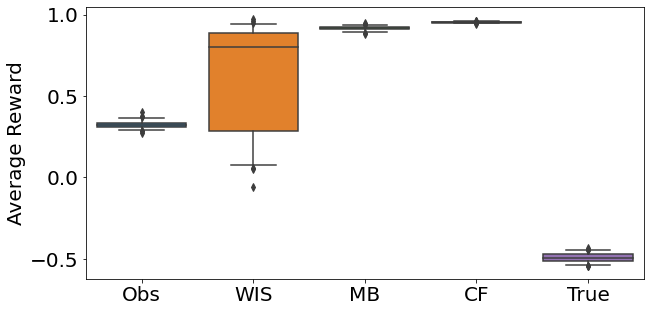

In [25]:
plt.rcParams.update({'font.size': 20})
reward = np.concatenate([obs_reward, 
                         offpol_opt_reward_WIS_hard,                         
#                         offpol_opt_reward_WIS_soft, 
                         offpol_opt_reward_mb,
                         offpol_opt_reward_cf,
                         true_rl_reward,
                         ], axis=1)
reward_df = pd.DataFrame(reward, columns=['Obs', 
                                          'WIS',
#                                          'WIS Soft',                                          
                                          'MB',
                                          'CF',
                                          'True'
                                         ])

plt.figure(figsize=(10,5))
sns.boxplot(data=reward_df, whis=[2.5, 97.5])
plt.ylabel("Average Reward")
plt.savefig("{}/{}-ope_wis_mb_cf_true.pdf".format(
    figpath, fig_prefix))
plt.show()

In [26]:
print(("RESULTS:"
       "\n\tObserved Reward:  {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tTrue RL Reward:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tWIS Estimate:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tMB Estimate:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tCF Estimate:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}").format(
    obs_reward.mean(), 
    np.quantile(obs_reward, 0.025), 
    np.quantile(obs_reward, 0.975), 
    true_rl_reward.mean(), 
    np.quantile(true_rl_reward,0.025), 
    np.quantile(true_rl_reward, 0.975),
    offpol_opt_reward_WIS_hard.mean(), 
    np.quantile(offpol_opt_reward_WIS_hard,0.025), 
    np.quantile(offpol_opt_reward_WIS_hard,0.975),
    offpol_opt_reward_mb.mean(), 
    np.quantile(offpol_opt_reward_mb,0.025), 
    np.quantile(offpol_opt_reward_mb,0.975),
    offpol_opt_reward_cf.mean(), 
    np.quantile(offpol_opt_reward_cf,0.025), 
    np.quantile(offpol_opt_reward_cf,0.975)
))

RESULTS:
	Observed Reward:  0.3240 	 95% Range: 0.2889 to 0.3692
	True RL Reward:	 -0.4907 	 95% Range: -0.5405 to -0.4445
	WIS Estimate:	 0.6286 	 95% Range: 0.0680 to 0.9458
	MB Estimate:	 0.9164 	 95% Range: 0.8950 to 0.9365
	CF Estimate:	 0.9531 	 95% Range: 0.9460 to 0.9600


# Counterfactuals

In [27]:
this_cf_opt_samps_proj = saved_material['cf_samps']
cf_obs_samps = saved_material['obs_samps']

In [28]:
colTime = 0
colAction = 1
colS0 = 2
colS1 = 3
colDiab = 4
colR = 6

In [29]:
obs_vs_cf_reward = pd.DataFrame(
    np.zeros((NSIMSAMPS, 2)),
    columns = ['Obs Reward', 'CF Reward'])

for obs_idx in range(NSIMSAMPS):
    # Get the MAP counterfactual reward
    cf_r_all = this_cf_opt_samps_proj[obs_idx][..., colR].sum(axis=-1)
    (_, idx, cts) = np.unique(cf_r_all, return_index=True, return_counts=True)
    cf_idx = idx[np.argmax(cts)]
    cf_r = cf_r_all[cf_idx]
    assert cf_r in [-1, 0, 1]    
    
    # Get the observed reward
    obs_r = cf_obs_samps[obs_idx][..., colR].sum()
    assert obs_r in [-1, 0, 1]
    
    obs_vs_cf_reward.iloc[obs_idx] = np.array([obs_r, cf_r])

In [30]:
result_mat = np.zeros((3, 3))

cf_idxs = [obs_vs_cf_reward['CF Reward'] == i for i in [-1, 0, 1]]
obs_idxs = [obs_vs_cf_reward['Obs Reward'] == i for i in [-1, 0, 1]]

import itertools
for i, j in itertools.product(range(3), range(3)):
    result_mat[i, j] = np.logical_and(obs_idxs[i], cf_idxs[j]).sum()
    
result_mat /= result_mat.sum()

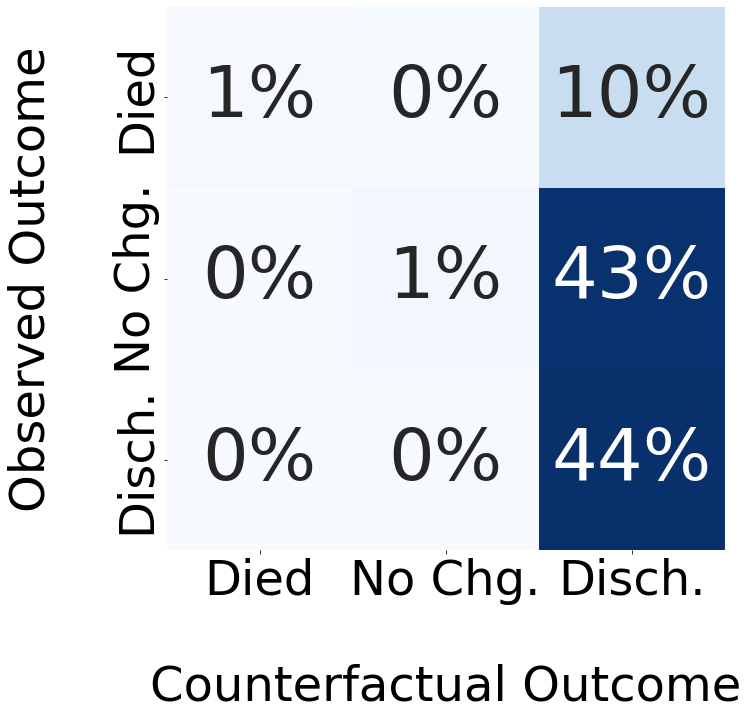

In [31]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 48})
ax = sns.heatmap(result_mat, annot=True, 
                 annot_kws={'fontsize': 72},
                 fmt='.0%', cbar=False, cmap='Blues')
ax.set_xlabel("\nCounterfactual Outcome")
ax.set_ylabel("Observed Outcome\n")
ax.set_xticklabels(['Died', 'No Chg.', 'Disch.'])
ax.set_yticklabels(['Died', 'No Chg.', 'Disch.'])
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_verticalalignment('center')
plt.savefig("{}/{}-optimistic_decomp.pdf".format(figpath, fig_prefix), bbox_inches='tight')
plt.show()

In [32]:
would_have_lived_idx = np.logical_and(cf_idxs[2], obs_idxs[0])
print("There are {} patients who the model believes would have been discharged".format(
would_have_lived_idx.sum()))

There are 103 patients who the model believes would have been discharged


In [39]:
print(cf_obs_samps)
selected_obs_trajectories = cf_obs_samps
selected_cf_trajectories = this_cf_opt_samps_proj[would_have_lived_idx]
num_selected_traj = selected_obs_trajectories.shape[0]

[[[  0.   4. 368. ...   0.   0.   0.]
  [  1.   4. 332. ...   0.   0.   0.]
  [  2.   4. 332. ...   0.   0.   0.]
  ...
  [ 17.   4. 372. ...   0.   0.   0.]
  [ 18.   4. 332. ...   0.   0.   0.]
  [ 19.   4. 332. ...   0.   0.   0.]]

 [[  0.   6. 288. ...   0.   0.   0.]
  [  1.   6. 293. ...   0.   0.   0.]
  [  2.   6. 293. ...   0.   0.   0.]
  ...
  [ 17.   6. 285. ...   0.   0.   0.]
  [ 18.   6. 285. ...   0.   0.   0.]
  [ 19.   6. 285. ...   0.   0.   0.]]

 [[  0.   7. 456. ...   0.   0.   0.]
  [  1.   7. 463. ...   0.   0.   0.]
  [  2.   7. 463. ...   0.   0.   0.]
  ...
  [ 17.  -1.  -1. ...   0.   0.   0.]
  [ 18.  -1.  -1. ...   0.   0.   0.]
  [ 19.  -1.  -1. ...   0.   0.   0.]]

 ...

 [[  0.   5. 136. ...   0.   0.   0.]
  [  1.   3. 222. ...   0.   0.   0.]
  [  2.   3. 219. ...   0.   0.   0.]
  ...
  [ 17.   3. 219. ...   0.   0.   0.]
  [ 18.   7. 459. ...   0.   0.   0.]
  [ 19.   7. 463. ...   0.   0.   0.]]

 [[  0.   7. 296. ...   1.   1.   0.]
  [  1.   6.

In [38]:
# Get lengths as the time until action = -1
obs_lengths = np.ones(num_selected_traj)*NSTEPS
for traj_idx in range(num_selected_traj):
    for time_idx in range(NSTEPS):
        if selected_obs_trajectories[traj_idx, time_idx, colR] != 0:
            #print("Setting {} to length {}".format(traj_idx, time_idx))
            obs_lengths[traj_idx] = time_idx
            break

obs_lengths = obs_lengths.astype(int)
print(np.mean(obs_lengths))


6.70873786407767


In [35]:
# This gives all of the trajectories with a reasonable length, for further inspection
np.where(obs_lengths > 10)

(array([16, 19, 20, 21, 22, 28, 30, 36, 43, 45, 47, 52, 58, 63, 66, 67, 71,
        74, 77, 82, 85, 86, 87, 88, 92, 96, 97]),)

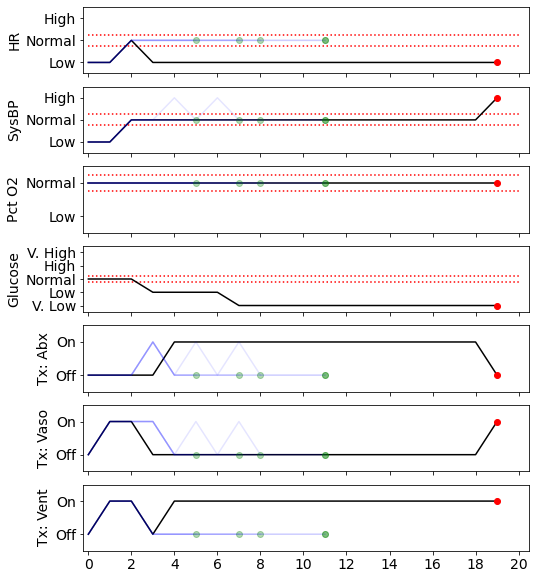

In [36]:
plt.rcParams.update({'font.size': 14})

# RL policy attempts no treatment from the start, mistake due to glucose
# 16; 20; 21; 30; 45; 47; 52; 58; 66; 71; 74; 77; 82; 85; 97

# RL policy thinks it could have stabilized, then discharged, but glucose would still have been off
# 19*; 28; 43; 67; 86*; 87*; 88; 96

# RL policy thinks it could have stabilized, then discharged;  Might be correct, glucose was not abnormal
# 22; 36; 92

# Other
# 63; 

traj_idx = 86

fig, axes = utils.plot_trajectory(
        selected_obs_trajectories, 
        pt_idx=traj_idx, 
        cf=True, 
        cf_samps=selected_cf_trajectories, 
        cf_proj=True
        )

plt.savefig('{}/{}-example-trajectory-{}.pdf'.format(figpath, fig_prefix, traj_idx), bbox_inches='tight')
plt.show()